In [1]:
import os
import sys
import time
import glob
import shutil
import datetime
import subprocess

import cv2
import numpy as np
from PIL import Image
from ipywidgets import Video
from matplotlib import pyplot as plt

In [2]:
from utils import get_image_from_url, build_video_from_images, distance
from face_model import FaceModelWrapper
from visualize_detection import visualize_face_detection, visualize_face_align, \
    visualize_face_recognition


model = FaceModelWrapper.from_file('config.json')

loading  pretrain/arcface/model-y1-test2/model


501it [00:00, 5904.32it/s]


In [3]:
# Warm up
warm_up_img = cv2.imread('/media/disk2/thanhtc/o2o/data/debug/chaewon3.png')
_, _, _ = model.detect_and_extract_embedding(warm_up_img)

video_src = '/media/disk2/thanhtc/o2o/data/debug/friends.mp4'
video_dir, video_file = os.path.split(video_src)
video_name = os.path.splitext(video_file)[0]

tmp_dir = '/media/disk2/thanhtc/o2o/data/debug/tmp'
if os.path.exists(tmp_dir):
    shutil.rmtree(tmp_dir)
os.makedirs(tmp_dir)

video_capture = cv2.VideoCapture(video_src)
n_frames = 0
start_time = time.time()
max_frames = -1

time_per_ops = []
while True:
    if video_capture.isOpened():
        status, frame = video_capture.read()
        if frame is not None:
            n_frames += 1
            start_op = time.time()
            bboxs, identities = model.predict_identity(frame)
            time_per_ops.append(time.time() - start_op)
            if bboxs is None:
                cv2.imwrite(os.path.join(tmp_dir, f'img{n_frames}.png'), frame)
                continue
            for box, identity in zip(bboxs, identities):
                box = box.astype(np.int)
                color = (0, 0, 255)
                cv2.rectangle(frame, (box[0], box[1]), (box[2], box[3]), color, 2)
                
                if identity:
                    cv2.putText(frame, identity, (box[0], box[3] + 40),
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2,
                                cv2.LINE_AA)
            
            cv2.imwrite(os.path.join(tmp_dir, f'img{n_frames}.png'), frame)
        if not status or (max_frames > 0 and n_frames >= max_frames):
            break

print(f'Time: {time.time() - start_time} - Num frames: {n_frames} '
      f'- Fps (ops): {n_frames / sum(time_per_ops)} '
      f'- Fps (all): {n_frames / (time.time() - start_time)}')

Time: 313.84241676330566 - Num frames: 4944 - Fps (ops): 26.729578014840563 - Fps (all): 15.753126780231842


In [83]:
# tmp_video = os.path.join(video_dir, video_name + '_mpeg.mp4')
# output_video = os.path.join(video_dir, video_name + '_h264.mp4')
# if os.path.exists(tmp_video):
#     os.remove(tmp_video)
# if os.path.exists(output_video):
#     os.remove(output_video)

# height, width, _ = detected_frames[0].shape
# fourcc = cv2.VideoWriter_fourcc(*'mp4v')
# video_writer = cv2.VideoWriter(tmp_video, fourcc, 30, (width, height))
# for i, image in enumerate(detected_frames):
#     video_writer.write(image)
# video_writer.release()

# os.system(f'ffmpeg -i {tmp_video} -vcodec libx264 -acodec aac {output_video}')

0

In [4]:
output_video = os.path.join(video_dir, video_name + '_detected.mp4')
if os.path.exists(output_video):
    os.remove(output_video)

build_video_from_images(tmp_dir, output_video)

In [5]:
face_detection_video = Video.from_file(output_video)
face_detection_video

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x01w\xea\xf5mdat\x00\x…

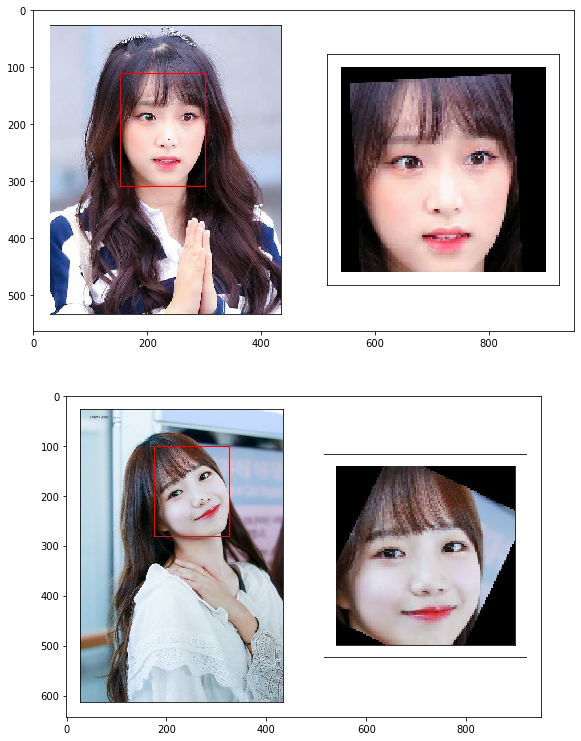

In [3]:
img_path_1 = '/media/disk2/thanhtc/o2o/data/debug/yena.jpg'
img_path_2 = '/media/disk2/thanhtc/o2o/data/debug/yuri.jpg'
img_1 = cv2.imread(img_path_1)
align_img_1_viz = visualize_face_align(model, img_1)
img_2 = cv2.imread(img_path_2)
align_img_2_viz = visualize_face_align(model, img_2)

fig = plt.figure(figsize=(13, 13))
ax = fig.add_subplot(2, 1, 1)
ax.imshow(align_img_1_viz[:, :, ::-1])
ax = fig.add_subplot(2, 1, 2)
ax.imshow(align_img_2_viz[:, :, ::-1])
plt.show()

In [6]:
s = time.time()
_, _, embs_1 = model.detect_and_extract_embedding(img_1)
print(time.time() - s)

s = time.time()
_, _, embs_2 = model.detect_and_extract_embedding(img_2)
print(time.time() - s)

distance(embs_1, embs_2)  # 1.1675067

0.036620378494262695
0.02306818962097168


array([1.165159], dtype=float32)

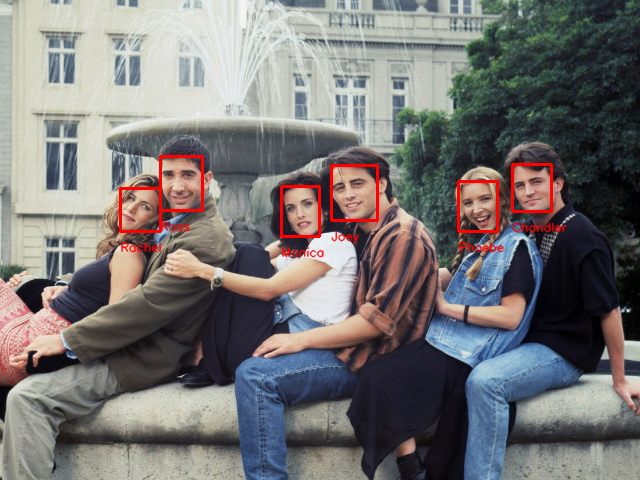

In [3]:
url = 'https://image.insider.com/5da6e0c9045a3132b57ef404?width=1100&format=jpeg&auto=webp'

img = get_image_from_url(url)
img = img[:, :, ::-1]
img = cv2.resize(img, (640, 480))

detection_img = visualize_face_recognition(model, img)

display(Image.fromarray(detection_img[:, :, ::-1]))